# Imprinting

I'd like to look at imprinting.

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'imprinting')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'imprinting')
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

## Imprinted Genes

I'll get some known imprinted genes.

### geneimprint.com

I'm going to get the imprinted genes from geneimprint.com. 

In [4]:
fn = os.path.join(outdir, 'geneimprint.tsv')
if not os.path.exists(fn):
    geneimprint = pd.read_html('http://www.geneimprint.com/site/genes-by-species.Homo+sapiens')[0]
    geneimprint.columns = geneimprint.ix[0]
    geneimprint = geneimprint.drop(0)
    geneimprint = geneimprint[geneimprint.Status.apply(lambda x: x in ['Predicted', 'Imprinted'])]
    
    # Now I'll convert the geneimprint gene names into gencode gene IDs. I'll drop any genes I can't
    # convert.
    ind = []
    drop = []
    for i in geneimprint.index:
        name = geneimprint.ix[i, 'Gene'].strip('*')
        tdf = gene_info[gene_info.gene_name == name]
        if tdf.shape[0] == 1:
            ind.append(tdf.index[0])
        else:
            names = []
            if type(geneimprint.ix[i, 'Aliases']) == unicode:
                names += [x.strip() for x in geneimprint.ix[i, 'Aliases'].split(',')]
            tdf = gene_info[gene_info.gene_name.apply(lambda x: x in names)].drop_duplicates()
            if tdf.shape[0] == 1:
                ind.append(tdf.index[0])
            else:
                drop.append(i)
    print('Dropping {} geneimprint genes'.format(len(drop)))
    geneimprint = geneimprint.drop(drop)
    geneimprint.index = ind
    for c in geneimprint.columns:
        ind = geneimprint[geneimprint[c].isnull() == False].index
        geneimprint.ix[ind, c] = geneimprint.ix[ind, c].apply(lambda x: x.encode('ascii', 'ignore'))
    geneimprint.columns = [x.encode('ascii', 'ignore') for x in geneimprint.columns]
    geneimprint.to_csv(fn, sep='\t')
else:
    geneimprint = pd.read_table(fn, index_col=0)

### [Babak et al. 2015](http://www.ncbi.nlm.nih.gov/pubmed/258487520)

Human imprinted genes from Babak. The values in `babak_cs` are their "combined scores."
A combined score greater than zero is evidence for imprinting. `babak_cs` has the combined score
for 94 genes in 45 different different tissues. 

I'm not going to filter the genes from Babak yet. I may want to remove genes from other
sources if they don't have imprinting in many tissues according to Babak.

TODO: Can I get imprinting direction from Babak?

In [5]:
fn = os.path.join(outdir, 'babak.tsv')
if not os.path.exists(fn):
    babak_cs = pd.read_excel('http://www.nature.com/ng/journal/v47/n5/extref/ng.3274-S11.xlsx',
                             sheetname='SuppFile_5', skiprows=213, skip_footer=503-309, index_col=0)
    babak_cs = babak_cs > 0

    # Now I'll convert the Babak gene names into gencode gene IDs. I'll drop any genes I can't
    # convert.
    ind = []
    drop = []
    for i in babak_cs.index:
        tdf = gene_info[gene_info.gene_name == i.strip('-new')]
        if tdf.shape[0] == 1:
            ind.append(tdf.index[0])
        else:
            drop.append(i)
    print('Dropping {} Babak genes'.format(len(drop)))
    babak_cs = babak_cs.drop(drop)
    babak_cs.index = ind
    babak_cs.to_csv(fn, sep='\t')
else:
    babak_cs = pd.read_table(fn, index_col=0)

### [Baran et al. 2015](http://genome.cshlp.org/content/25/7/927.full)

I'm not going to filter the genes from Babak yet. I may want to remove genes from other
sources if they don't have imprinting in many tissues according to Baran.

In [6]:
fn = os.path.join(outdir, 'baran.tsv')
if not os.path.exists(fn):
    url = 'http://genome.cshlp.org/content/suppl/2015/05/20/gr.192278.115.DC1/Supp_Tables_S1-4_6-7.xlsx'
    baran = pd.read_excel(url, sheetname='Table_S6')
    baran_fam = pd.read_excel(url, sheetname='Table_S7')

    # I want to figure out which genes validated in the family data and what their imprinting status is .
    g = set(baran_fam.Gene) & set(baran.Human_Genename)
    baran_status = {}
    for gene in g:
        t = baran_fam[baran_fam.Gene == gene]
        if sum(t.Imprinting_status.apply(lambda x: 'Paternally expressed' in x)) == t.shape[0]:
            baran_status[gene] = 'Paternal'
        elif sum(t.Imprinting_status.apply(lambda x: 'Maternally expressed' in x)) == t.shape[0]:
            baran_status[gene] = 'Maternal'
    baran['ExpressedAllele'] = np.nan
    # Note that I'm requiring all tissues to have the same direction to consider something validated.
    # This is stringent.
    baran['validated'] = np.nan
    for gene in baran_status.keys():
        baran.ix[baran.Human_Genename == gene, 'ExpressedAllele'] = baran_status[gene]
        baran.ix[baran.Human_Genename == gene, 'validated'] = True
    for gene in set(baran_fam.Gene) - set(baran_status.keys()):
        baran.ix[baran.Human_Genename == gene, 'validated'] = False
    se = pd.Series(gene_info.index, index=gene_info.ensembl_id)
    baran['gencode_id'] = se[baran.Human_GeneID].values
    baran = baran.dropna(subset=['gencode_id'])
    baran.index = baran.gencode_id
    baran.to_csv(fn, sep='\t')
else:
    baran = pd.read_table(fn, index_col=0)

### Combine different sources

I'll keep the genes that have evidence for imprinting in more than 5 tissues 
from Babak et al. and that were marked as "imprinted" or "consistent with imprinted"
from Baran et al.

In [7]:
fn = os.path.join(outdir, 'igenes.tsv')
if not os.path.exists(fn):
    babak_cs_f = babak_cs[babak_cs.sum(axis=1) >= 5]
    babak_not_imp = set(babak_cs.index) - set(babak_cs_f.index)

    vals = ['imprinted', 'consistent with imprinted']
    baran_f = baran[(baran.Imprinting_status_Baran.apply(lambda x: x in vals)) & 
                    (baran.validated != False)]
    baran_not_imp = set(baran.index) - set(baran_f.index)

    # Now I'll make a dataframe indexed by Gencode gene ID and filled in with some
    # of the info I have available.
    g = set(geneimprint.index) | set(babak_cs_f.index) | set(baran_f.index)
    igenes = pd.DataFrame(index=g, columns=['geneimprint', 'babak', 'baran', 
                                            'expressed_allele', 'num_babak_tissues'])

    igenes['geneimprint'] = False
    igenes.ix[geneimprint.index, 'geneimprint'] = True
    igenes['babak'] = False
    igenes.ix[babak_cs_f.index, 'babak'] = True
    igenes['baran'] = False
    igenes.ix[baran_f.index, 'baran'] = True

    # I thought about dropping genes with evidence against imprinting from Babak or Baran
    # but I think I want to be more inclusive. I think the papers could have false negatives.
    # I see a stronger enrichment for ASE when I don't remove these genes (arguing some are 
    # printed) although the enrichment exists either way.
    # igenes = igenes.drop((babak_not_imp | baran_not_imp) & set(igenes.index))

    ind = set(geneimprint.index) & set(igenes.index)
    igenes.ix[ind, 'expressed_allele'] = geneimprint.ix[ind, 'ExpressedAllele']

    # Add info on imprinting status if I have it.
    t = baran_f.dropna(subset=['ExpressedAllele'])
    ind = set(t.index) & set(igenes.index)
    igenes.ix[ind, 'expressed_allele'] = t.ix[ind, 'ExpressedAllele']

    # Add info on number of tissues imprinted in.
    se = babak_cs.sum(axis=1)
    ind = set(igenes.index) & set(se.index)
    igenes.ix[ind, 'num_babak_tissues'] = se[ind].values
    igenes.to_csv(fn, sep='\t')
else:
    igenes = pd.read_table(fn, index_col=0)

TODO: I may want to try to convert more of the genes from geneimprint. I can use mygene.info:

    import mygene
    mg = mygene.MyGeneInfo()
    res = mg.query('symbol:HYMAI', species='human')

## ASE

Are imprinted genes enriched for having ASE?

In [8]:
t = locus_p.ix[:, :, 'p_val_ase']
t_igenes = t.ix[set(t.index) & set(igenes.index) - set(gene_info[gene_info.chrom == 'chrX'].index)]
t_igenes = t_igenes[t_igenes.isnull().sum(axis=1) / t_igenes.shape[1] < 0.5]
t_not_igenes = t.ix[set(t.index) - set(igenes.index) - set(gene_info[gene_info.chrom == 'chrX'].index)]
t_not_igenes = t_not_igenes[t_not_igenes.isnull().sum(axis=1) / t_not_igenes.shape[1] < 0.5]

In [9]:
a = (t_igenes < 0.005).sum() / (t_igenes.isnull() == False).sum()
b = (t_not_igenes < 0.005).sum() / (t_not_igenes.isnull() == False).sum()
print('Average number of significant ASE samples per gene ' 
      'for {} imprinted genes: {:.2f}%.'.format(t_igenes.shape[0], a.mean() * 100))
print('Average number of significant ASE samples per gene ' 
      'for {} non-imprinted genes: {:.2f}%.'.format(t_not_igenes.shape[0], b.mean() * 100))

Average number of significant ASE samples per gene for 51 imprinted genes: 13.34%.
Average number of significant ASE samples per gene for 5423 non-imprinted genes: 3.07%.


In [10]:
r = stats.mannwhitneyu(a, b)
print('The average number of samples with ASE is significantly '
      'different between imprinted and non-imprinted genes with p={:.3e}.'.format(r.pvalue))

The average number of samples with ASE is significantly different between imprinted and non-imprinted genes with p=7.610e-80.


In [11]:
log_tpm = np.log10(tpm + tpm[tpm > 0].min().min())

In [12]:
r = stats.mannwhitneyu(log_tpm.ix[t_not_igenes.index].mean(axis=1), log_tpm.ix[t_igenes.index].mean(axis=1))
print('The average TPM expression between the imprinted and non-imprinted genes is comparable '
      'p={:.2f}.'.format(r.pvalue))

The average TPM expression between the imprinted and non-imprinted genes is comparable p=0.40.


## CARDiPS Trios and Phasing

I can find CARDiPS subjects for which we have WGS for both parents so that I can 
accurately assign parental haplotypes.

In [14]:
# I'll keep children where we have WGS data for both parents and RNA-seq data for the child.
trio_child = subject_meta.dropna(subset=['father_id', 'mother_id'])
trio_child = trio_child[trio_child.father_id.apply(lambda x: x in wgs_meta.subject_id.values)]
trio_child = trio_child[trio_child.mother_id.apply(lambda x: x in wgs_meta.subject_id.values)]
trio_child = trio_child[[x in rna_meta.subject_id.values for x in trio_child.index]]
print('{} trio children'.format(trio_child.shape[0]))

24 trio children


Let's filter the imprinted genes to those where we estimated ASE in at 
least one trio child.

In [15]:
trio_child['wgs_id'] = [wgs_meta[wgs_meta.subject_id == x].index[0] for x in trio_child.index]
trio_child['father_wgs_id'] = [wgs_meta[wgs_meta.subject_id == x].index[0] for x in trio_child.father_id]
trio_child['mother_wgs_id'] = [wgs_meta[wgs_meta.subject_id == x].index[0] for x in trio_child.mother_id]
def get_rna_sample(sid):
    tdf = rna_meta[rna_meta.subject_id == sid]
    if tdf.shape[0] == 1:
        rna_sample = tdf.index[0]
    elif tdf[tdf.in_eqtl].shape[0] == 1:
        rna_sample = tdf[tdf.in_eqtl].index[0]
    elif tdf[tdf.in_222].shape[0] == 1:
        rna_sample = tdf[tdf.in_22].index[0]
    else:
        rna_sample = np.nan
    return rna_sample
trio_child['rna_id'] = [get_rna_sample(x) for x in trio_child.index]

In [16]:
trio_child_ase_pval = ase_pval[trio_child.rna_id]
igenes_f = igenes.ix[set(igenes.index) & set(trio_child_ase_pval.index)]
trio_child_ase_pval = trio_child_ase_pval.ix[igenes_f.index]
trio_child_ase_pval = trio_child_ase_pval.ix[set(trio_child_ase_pval.index) - 
                                             set(gene_info[gene_info.chrom == 'chrX'].index)]

In [17]:
def imprinting_analysis(child, gene_id):
    # Make data frame with SNV-level results for this sample and gene.
    snv_df = snv_p.ix[trio_child.ix[child, 'rna_id']]
    snv_df = snv_df[snv_df.locus == gene_id]

    # Let's get a 1MB region centered on the gene and get all variants in this
    # region. We'll look for variants that are het in the child and homozygous
    # alt/ref in the parents so we can determine the parental haplotype.
    chrom = gene_info.ix[gene_id, 'chrom']
    start = gene_info.ix[gene_id, 'start']
    end = gene_info.ix[gene_id, 'end']
    slop = (1000000 - (end - start)) / 2
    bt = pbt.BedTool('{}\t{}\t{}'.format(chrom, start, end), from_string=True)
    bt = bt.slop(b=slop, g=pbt.genome_registry.hg19)
    df = bt.to_dataframe()
    if df.ix[0, 'end'] - df.ix[0, 'start'] != 1000000:
        if df.ix[0, 'start'] == 0:
            bt = bt.slop(l=0, r=1000000 - (df.ix[0, 'end'] - df.ix[0, 'start']), 
                         g=pbt.genome_registry.hg19)
            df = bt.to_dataframe()
        else:
            bt = bt.slop(r=0, l=1000000 - (df.ix[0, 'end'] - df.ix[0, 'start']), 
                         g=pbt.genome_registry.hg19)
            df = bt.to_dataframe()
    start = df.ix[0, 'start']
    end = df.ix[0, 'end']
    os.remove(bt.fn)

    fn = ('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/'
          'CARDIPS_{}_phased.vcf.gz'.format(gene_info.ix[gene_id, 'chrom']))
    vcf_reader = pyvcf.Reader(open(fn))
    res = vcf_reader.fetch(gene_info.ix[gene_id, 'chrom'][3:], start, end)

    variants = []
    for r in res:
        g = r.genotype(trio_child.ix[child, 'wgs_id'])
        if g.called and g.is_het:
            mg = r.genotype(trio_child.ix[child, 'mother_wgs_id'])
            fg = r.genotype(trio_child.ix[child, 'father_wgs_id'])
            if mg.called and fg.called:
                if set(mg.gt_alleles) == set('0') and set(fg.gt_alleles) == set('1'):
                    variants.append(r)
                elif set(mg.gt_alleles) == set('1') and set(fg.gt_alleles) == set('0'):
                    variants.append(r)

    left_hap_father = 0
    for r in variants:
        g = r.genotype(trio_child.ix[child, 'wgs_id'])
        fg = r.genotype(trio_child.ix[child, 'father_wgs_id'])
        if g.gt_alleles[0] == fg.gt_alleles[0]:
            left_hap_father += 1

    if left_hap_father > len(variants) / 2:
        father_hap = 0
    else:
        father_hap = 1

    snv_df.loc[:, 'preference'] = ''
    for i in snv_df.index:
        r = vcf_reader.fetch(gene_info.ix[gene_id, 'chrom'][3:], snv_df.ix[i, 'position'])
        g = r.genotype(trio_child.ix[child, 'wgs_id'])
        if snv_df.ix[i, 'ref_is_major'] and g.gt_alleles[father_hap] == '0':
            snv_df.loc[i, 'preference'] = 'paternal'
        elif snv_df.ix[i, 'ref_is_major'] and g.gt_alleles[father_hap] == '1':
            snv_df.loc[i, 'preference'] = 'maternal'
        elif snv_df.ix[i, 'ref_is_major'] == False and g.gt_alleles[father_hap] == '0':
            snv_df.loc[i, 'preference'] = 'maternal'
        elif snv_df.ix[i, 'ref_is_major'] == False and g.gt_alleles[father_hap] == '1':
            snv_df.loc[i, 'preference'] = 'paternal'
        else:
            print('problem for {}'.format(i))
#     vc = snv_df.preference.value_counts()
#     if vc.shape[0] == 1:
#         preference = vc.index[0]
#     if vc.shape[0] == 2:
#         if vc['maternal'] == vc['paternal']:
#             preference = 'unknown'
#         else:
#             prefernce = vc.index[0]
    return (gene_id, child, ase_pval.ix[gene_id, trio_child.ix[child, 'rna_id']], snv_df)

In [20]:
fn = os.path.join(outdir, 'results.pickle')
if not os.path.exists(fn):
    from ipyparallel import Client
    #parallel_client = Client(profile='parallel')
    parallel_client = Client()
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        import pybedtools
        import os
        import vcf

    %px cpb = cdpybio
    %px cpy = cardipspy
    %px pbt = pybedtools
    %px pyvcf = vcf

    dview.push(dict(imprinting_analysis=imprinting_analysis, snv_p=snv_p, 
                    gene_info=gene_info, trio_child=trio_child, ase_pval=ase_pval));

    pairs = []
    for gene_id in trio_child_ase_pval.index:
        se = trio_child_ase_pval.ix[gene_id].dropna()
        for rna_id in se.index:
            child = trio_child[trio_child.rna_id == rna_id].index[0]
            pairs.append((child, gene_id))

    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in xrange(0, len(l), n):
            yield l[i:i+n]

    # It would be faster if I didn't do this in chunks but I ran into an error
    # and this fixed it. However, I think I should probably try them all at the 
    # same time again at some point.
    c = chunks(pairs, len(dview))
    results = []
    while True:
        try:
            results += dview.map_sync(lambda x: imprinting_analysis(x[0], x[1]), c.next())
        except StopIteration:
            break
            
#     results = dview.map_sync(lambda x: imprinting_analysis(x[0], x[1]), pairs[0:10])
#     results = results.get()
            
    with open(fn , 'w') as f:
        cPickle.dump(results, f)

else:
    results = cPickle.load(open(fn))

In [21]:
df = pd.DataFrame([x[0:3] for x in results], columns=['gene_id', 'sample_id', 'p_value'])
df['maternal_percent'] = 0
df['paternal_percent'] = 0
for i,x in enumerate(results):
    vc = x[-1].preference.value_counts()
    if 'paternal' in vc.index:
        df.ix[i, 'paternal_percent'] = vc['paternal'] / float(vc.sum())
    if 'maternal' in vc.index:
        df.ix[i, 'maternal_percent'] = vc['maternal'] / float(vc.sum())
df['num_snvs'] = [x[-1].shape[0] for x in results]

In [22]:
df = df.merge(igenes_f.dropna(subset=['expressed_allele'])[['expressed_allele']], 
              left_on='gene_id', right_index=True)

In [23]:
pat = df.ix[df.paternal_percent > df.maternal_percent, 'gene_id']
mat = df.ix[df.maternal_percent > df.paternal_percent, 'gene_id']
pat_pat = sum(igenes_f.ix[pat, 'expressed_allele'] == 'Paternal')
mat_mat = sum(igenes_f.ix[mat, 'expressed_allele'] == 'Maternal')
pat_mat = sum(igenes_f.ix[pat, 'expressed_allele'] == 'Maternal')
mat_pat = sum(igenes_f.ix[mat, 'expressed_allele'] == 'Paternal')

odds, pvalue = stats.fisher_exact([[pat_pat, pat_mat], [mat_pat, mat_mat]])
print('Imprinted genes are more likely to show bias in '
      'the direction they are imprinted: odds={:.3f}, p={:.2e}.'.format(odds, pvalue))

Imprinted genes are more likely to show bias in the direction they are imprinted: odds=1.680, p=7.21e-04.


In [30]:
tdf = df[df.p_value < 0.005]
pat = tdf.ix[tdf.paternal_percent > tdf.maternal_percent, 'gene_id']
mat = tdf.ix[tdf.maternal_percent > tdf.paternal_percent, 'gene_id']
pat_pat = sum(igenes_f.ix[pat, 'expressed_allele'] == 'Paternal')
mat_mat = sum(igenes_f.ix[mat, 'expressed_allele'] == 'Maternal')
pat_mat = sum(igenes_f.ix[pat, 'expressed_allele'] == 'Maternal')
mat_pat = sum(igenes_f.ix[mat, 'expressed_allele'] == 'Paternal')

odds, pvalue = stats.fisher_exact([[pat_pat, pat_mat], [mat_pat, mat_mat]])
print('Imprinted genes with significant ASE are more likely to show bias in '
      'the direction they are imprinted: odds={:.3f}, p={:.2e}.'.format(odds, pvalue))
p = float(mat_mat + pat_pat) / (mat_mat + pat_pat + mat_pat + pat_mat)
print('\n{:.1f}% of genes with significant are biased in the correction direction.'.format(p * 100))

Imprinted genes with significant ASE are more likely to show bias in the direction they are imprinted: odds=8.085, p=2.53e-05.

74.7% of genes with significant are biased in the correction direction.


In [25]:
tdf = df[(df.expressed_allele == 'Maternal') | 
         (df.expressed_allele == 'Paternal')]
tdf = tdf[tdf.maternal_percent != tdf.paternal_percent]

In [26]:
t = locus_p.ix[trio_child.ix[set(tdf.sample_id), 'rna_id'], set(tdf.gene_id), 'major_allele_freq']
for i in tdf[tdf.maternal_percent > tdf.paternal_percent].index:
    r = trio_child.ix[tdf.ix[i, 'sample_id'], 'rna_id']
    t.ix[tdf.ix[i, 'gene_id'], r] = 1 - t.ix[tdf.ix[i, 'gene_id'], r]

In [27]:
tig = igenes.ix[t.index]

In [31]:
sns.set_context('talk', font_scale=1.5)

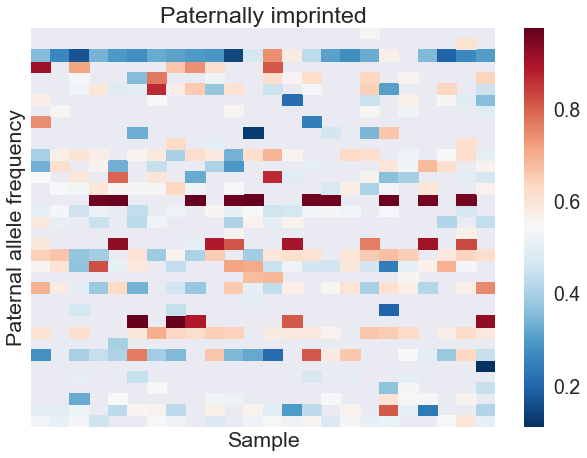

In [70]:
ax = sns.heatmap(t.ix[tig[tig.expressed_allele == 'Paternal'].index], xticklabels=[], yticklabels=[], cmap='RdBu_r')
ax.set_ylabel('Paternal allele frequency')
ax.set_xlabel('Sample')
ax.set_title('Paternally imprinted');

In [72]:
gene_info.ix['ENSG00000130844.12']

gene_name               ZNF331
gene_type       protein_coding
chrom                    chr19
start                 54024234
end                   54083523
strand                       +
gene_status              KNOWN
source                  HAVANA
level                        2
ensembl_id     ENSG00000130844
Name: ENSG00000130844.12, dtype: object

In [71]:
igenes_f.ix['ENSG00000130844.12']

geneimprint             False
babak                    True
baran                    True
expressed_allele     Paternal
num_babak_tissues          42
Name: ENSG00000130844.12, dtype: object

In [69]:
(t.ix[tig[tig.expressed_allele == 'Paternal'].index] < 0.5).sum(axis=1)

major_allele_freq
ENSG00000107485.11     0
ENSG00000198010.7      0
ENSG00000130844.12    20
ENSG00000185513.10     0
ENSG00000138061.7      1
ENSG00000005513.9      5
ENSG00000141441.11     4
ENSG00000248492.1      1
ENSG00000149289.6      1
ENSG00000114315.3      4
ENSG00000135324.5      0
ENSG00000112297.10     3
ENSG00000179163.11     5
ENSG00000066827.11     6
ENSG00000135211.5      2
ENSG00000242265.1      0
ENSG00000130816.10     5
ENSG00000172889.11     5
ENSG00000155621.10     0
ENSG00000204186.3      0
ENSG00000154358.15     5
ENSG00000116251.5      7
ENSG00000160345.8      0
ENSG00000221944.3      7
ENSG00000185559.9      0
ENSG00000256294.3      3
ENSG00000182636.4      0
ENSG00000106484.10     0
ENSG00000159674.7      1
ENSG00000121297.6     11
ENSG00000053438.7      1
ENSG00000189043.5      2
ENSG00000172733.10     2
ENSG00000073712.9      1
ENSG00000178821.8      8
ENSG00000187772.6      3
dtype: int64

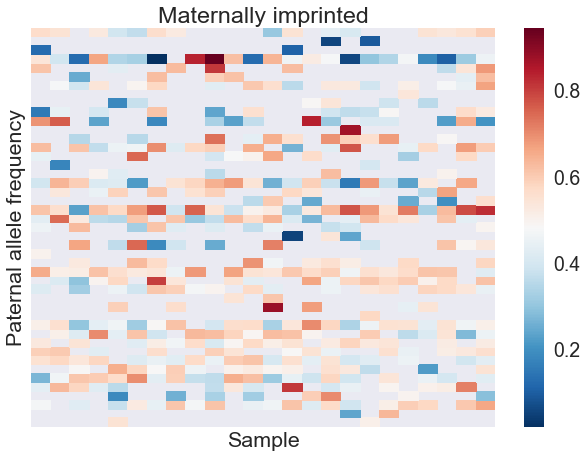

In [74]:
ax = sns.heatmap(t.ix[tig[tig.expressed_allele == 'Maternal'].index], xticklabels=[], yticklabels=[], cmap='RdBu_r')
ax.set_ylabel('Paternal allele frequency')
ax.set_xlabel('Sample')
ax.set_title('Maternally imprinted');

In [52]:
igenes.ix['ENSG00000187391.13']

geneimprint              True
babak                   False
baran                   False
expressed_allele     Maternal
num_babak_tissues           3
Name: ENSG00000187391.13, dtype: object

In [51]:
tig.ix['ENSG00000187391.13']

geneimprint              True
babak                   False
baran                   False
expressed_allele     Maternal
num_babak_tissues           3
Name: ENSG00000187391.13, dtype: object

In [56]:
t[t.isnull().sum(axis=1) == 0]

,6a5edde2-492a-49c9-978a-27c9bc889827,d307baca-b3cb-4301-b74b-c9384f298206,683d39a0-cc9d-4e6b-8778-f7bb98101a94,45c8234a-0cf0-4706-8dde-5f0cb7c38f3d,33297052-9bcb-41c9-b101-6a00c7c00c8f,843f5dd5-ec6b-496c-ae29-b4bc6c387280,3a3a7a84-4c7d-4b61-a210-5e56eafde5d3,4a452ef5-8015-4467-85ad-35a8bb60599e,ce1926ab-0eec-49a6-9675-94562566fa94,b3cc2866-5e83-4532-a19a-7e8fbf206f1c,...,f70fedfb-6638-4b7b-bf33-f9fb3e75d4fc,eb81d0ea-7263-4459-bb83-3de9894c60b2,9e5035d3-9ced-4b81-b77b-87d6aaf2631d,331f9a4a-7143-497b-a0fd-16863c82585a,349de0b8-ea4a-45eb-9631-8259b539f7b8,4e780564-c504-4860-9e24-6b7791007afb,4cf357ab-813c-4c84-bb33-d4f6233781ed,26f7236b-3334-494c-be8c-5b0ce3896423,9b7e0e0e-1ccd-4fc3-a06c-977522c5d6c8,9135588e-9a8e-4b15-b605-13e7ebd485bf
major_allele_freq,,,,,,,,,,,,,,,,,,,,,
ENSG00000145536.11,0.619144,0.564183,0.23619,0.622093,0.578782,0.681581,0.773913,0.397006,0.759145,0.55057,...,0.532734,0.634521,0.779523,0.688328,0.554002,0.728479,0.337483,0.633284,0.787381,0.82832
